# Chapter 4 - Classification

- [Load dataset](#Load-dataset)
- [The Default data set](#Figure-4.1---Default-data-set)
- [4.3 Logistic Regression](#4.3-Logistic-Regression)
- [4.4 Linear Discriminant Analysis](#4.4-Linear-Discriminant-Analysis)
- [Lab: 4.6.3 Linear Discriminant Analysis](#4.6.3-Linear-Discriminant-Analysis)
- [Lab: 4.6.4 Quadratic Discriminant Analysis](#4.6.4-Quadratic-Discriminant-Analysis)
- [Lab: 4.6.5 K-Nearest Neighbors](#4.6.5-K-Nearest-Neighbors)
- [Lab: 4.6.6 An Application to Caravan Insurance Data](#4.6.6-An-Application-to-Caravan-Insurance-Data)

In [9]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

In [10]:
pd.options.display.max_rows = 10

### Load dataset

In [11]:
df = pd.read_excel('Data/Default.xlsx')
df

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879
...,...,...,...,...
9996,No,No,711.555020,52992.378914
9997,No,No,757.962918,19660.721768
9998,No,No,845.411989,58636.156984
9999,No,No,1569.009053,36669.112365


In [12]:
# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

,default,student,balance,income,default2,student2
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0


###  Figure 4.1 - Default data set

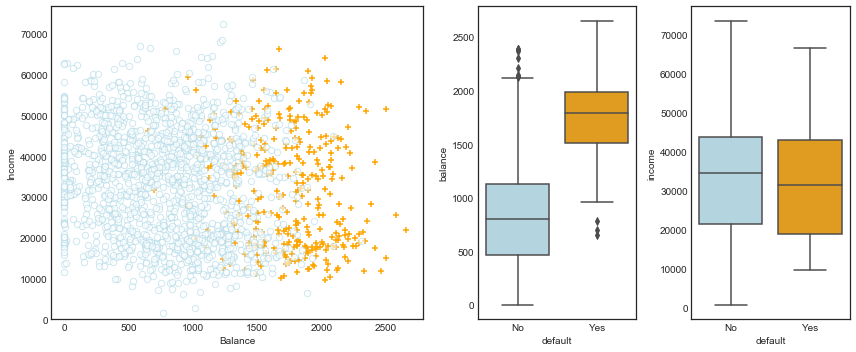

In [13]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

## 4.2 Why Not Linear Regression?

if we use linear regression, some of our estimates might be outside the [0, 1] interval (see Figure 4.2), making them hard to interpret as probabilities!

(Page 130). 

## 4.3 Logistic Regression
### Figure 4.2

C:\Users\idsoo\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\idsoo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


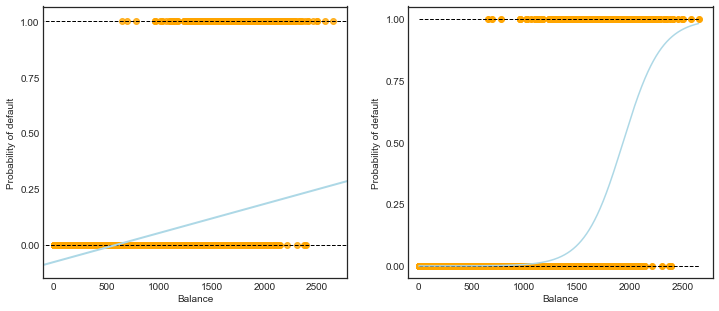

In [14]:
X_train = df.balance.values.reshape(-1,1) 
y = df.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(df.balance, df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

> FIGURE 4.2. Classification using the Default data. Left: Estimated probability of default using linear regression. Some estimated probabilities are negative! The orange ticks indicate the 0/1 values coded for default(No or Yes). Right: Predicted probabilities of default using logistic regression. All probabilities lie between 0 and 1.


### 4.3.1 The Logistic Model

In logistic regression, we use the ***logistic function,***

$$\large p(X) = \frac{e^{\beta_0+\beta_1X}}{1+e^{\beta_0+\beta_1X}}$$

To fit the model, we use a method called ***maximum likelihood,*** which we discuss in the next section. The right-hand panel of Figure 4.2 illustrates the fit of the logistic regression model to the Default data. Notice that for low balances we now predict the probability of default as close to, but never below, zero. Likewise, for high balances we predict a default probability close to, but never above, one. The logistic function will always produce an S-shaped curve of this form, and so regardless of the value of X, we will obtain a sensible prediction. We also see that the logistic model is better able to capture the range of probabilities than is the linear regression model in the left-hand plot. The average fitted probability in both cases is 0.0333 (averaged over the training data), which is the same as the overall proportion of defaulters in the data set. After a bit of manipulation of (4.2), we find that

$$\large \frac{p(X)}{1-p(X)} = e^{\beta_0+\beta_1X}$$

The quantity $p(X)/[1−p(X)]$ is called the odds, and can take on any value between 0 and $\infty$. Values of the odds close to 0 and $\infty$ indicate very low and very high probabilities of default, respectively. For example, on average 1 in 5 people with an odds of 1/4 will default, since $p(X)=0.2$ implies an odds of $\frac{0.2}{1−0.2} = 1/4$. Likewise on average nine out of every ten people with an odds of 9 will default, since $p(X)=0.9$ implies an odds of $\frac{0.9}{1−0.9} = 9$. Odds are traditionally used instead of probabilities in horse-racing, since they relate more naturally to the correct betting strategy. By taking the logarithm of both sides of (4.3), we arrive at

$$\large log(\frac{p(X)}{1-p(X)})=\beta_0 + \beta_1X$$

The left-hand side is called the ***log-odds or logit***. We see that the logistic regression model (4.2) has a logit that is linear in X.

Recall from Chapter 3 that in a linear regression model, $\beta_1$ gives the average change in $Y$ associated with a one-unit increase in X. In contrast, in a logistic regression model, increasing $X$ by one unit changes the log odds by $\beta_1$ (4.4), or equivalently it multiplies the odds by $e^{β_1} (4.3). However, because the relationship between $p(X)$ and $X$ in (4.2) is not a straight line,$\beta_1$ does not correspond to the change in p(X)$ associated with a one-unit increase in $X$. The amount that $p(X)$ changes due to a one-unit change in $X$ will depend on the current value of $X$. But regardless of the value of $X$, if $\beta_1$ is positive then increasing $X$ will be associated with increasing $p(X)$, and if $\beta_1$ is negative then increasing $X$ will be associated with decreasing $p(X)$. The fact that there is not a straight-line relationship between $p(X)$ and $X$, and the fact that the rate of change in $p(X)$ per unit change in $X$ depends on the current value of $X$, can also be seen by inspection of the right-hand panel of Figure 4.2.
. 

### 4.3.2 Estimating the Regression Coefficients

The coefficients $\beta_0$ and $\beta_1$ in (4.2) are unknown, and must be estimated based on the available training data. In Chapter 3, we used the least squares approach to estimate the unknown linear regression coefficients. Although we could use (non-linear) least squares to fit the model (4.4), the more general method of maximum likelihood is preferred, since it has better statistical properties. The basic intuition behind using ***maximum likelihood*** to fit a logistic regression model is as follows: we seek estimates for $\beta_0$ and $\beta_1$ such that the predicted probability $\hat{p}(x_i)$ of default for each individual, using (4.2), corresponds as closely as possible to the individual's observed default status. In other words, we try to find $\hat{\beta}_0$ and $\hat{\beta}_1$ such that plugging these estimates into the model for $p(X)$, given in (4.2), yields a number close to one for all individuals who defaulted, and a number close to zero for all individuals who did not. This intuition can be formalized using a mathematical equation called a ***likelihood function***:

$$\large l(\beta_0, \beta_1) = \Pi_{i:y_i=1}p(x_i) \Pi_{i':y_{i'}=0}(1-p(x_i'))$$

The estimates $\hat{\beta}_0$ and $\hat{\beta}_1$ are chosen to maximize this likelihood function. Maximum likelihood is a very general approach that is used to fit many of the non-linear models that we examine throughout this book. In the linear regression setting, the least squares approach is in fact a special case of maximum likelihood. The mathematical details of maximum likelihood are beyond the scope of this book. However, in general, logistic regression and other models can be easily fit using a statistical software package such as R, and so we do not need to concern ourselves with the details of the maximum likelihood fitting procedure.

(Page 133). 

#### Table 4.1

In [15]:
y = df.default2

#####  scikit-learn

In [16]:
# Using newton-cg solver, the coefficients are equal/closest to the ones in the book. 
# I do not know the details on the differences between the solvers.
clf = skl_lm.LogisticRegression(solver='newton-cg')
X_train = df.balance.values.reshape(-1,1)
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
classes:  [0 1]
coefficients:  [[0.00549892]]
intercept : [-10.65132997]


C:\Users\idsoo\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\idsoo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


##### statsmodels

In [17]:
X_train = sm.add_constant(df.balance)
est = smf.Logit(y.ravel(), X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


> TABLE 4.1. For the Default data, estimated coefficients of the logistic regression model that predicts the probability of default using balance. A one-unit increase in balance is associated with an increase in the log odds of default by 0.0055 units.


### 4.3.3 Making Predictions

One can use qualitative predictors with the logistic regression model using the dummy variable approach from Section 3.3.1. As an example, the Default data set contains the qualitative variable student. To fit the model we simply create a dummy variable that takes on a value of 1 for students and 0 for non-students. The logistic regression model that results from predicting probability of default from student status can be seen in Table 4.2. The coefficient associated with the dummy variable is positive, and the associated p-value is statistically significant.



####  Table 4.2

In [18]:
X_train = sm.add_constant(df.student2)
y = df.default2

est = smf.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student2,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


>TABLE 4.2. For the Default data, estimated coefficients of the logistic regression model that predicts the probability of default using student status. Student status is encoded as a dummy variable, with a value of 1 for a student and a value of 0 for a non-student, and represented by the variable student[Yes] in the table.


### 4.3.4 Multiple Logistic Regression

We now consider the problem of predicting a binary response using multiple predictors. By analogy with the extension from simple to multiple linear regression in Chapter 3, we can generalize (4.4) as follows:

$$log (\frac{p(X)}{1 − p(X)}) = \beta_0 + \beta_1X_1 + \dots + \beta_pX_p$$

where $X = (X_1,\dots,X_p)$ are $p$ predictors. Equation 4.6 can be rewritten as

$$p(X) = \frac{e^{\beta_0+\beta_1X_1+\dots+\beta_pX_p}}{1+e^{\beta_0+\beta_1X_1+\dots+\beta_pX_p}}$$

Just as in Section 4.3.2, we use the maximum likelihood method to estimate $\beta_0 , \beta_1 , \dots ,\beta_p$

(Page 135). 

####  Table 4.3 - Multiple Logistic Regression

In [19]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = smf.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
income,0.000003,0.000008,0.369808,7.115254e-01,-0.000013,0.000019
student2,-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721


>TABLE 4.3. For the Default data, estimated coefficients of the logistic regression model that predicts the probability of default using balance, income, and student status. Student status is encoded as a dummy variable student[Yes], with a value of 1 for a student and a value of 0 for a non-student. In fitting this model, income was measured in thousands of dollars.



### Figure 4.3 - Confounding

In [20]:
# balance and default vectors for students
X_train = df[df.student == 'Yes'].balance.values.reshape(df[df.student == 'Yes'].balance.size,1) 
y = df[df.student == 'Yes'].default2

# balance and default vectors for non-students
X_train2 = df[df.student == 'No'].balance.values.reshape(df[df.student == 'No'].balance.size,1) 
y2 = df[df.student == 'No'].default2

# Vector with balance values for plotting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf2 = skl_lm.LogisticRegression(solver='newton-cg')

clf.fit(X_train,y)
clf2.fit(X_train2,y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)

In [21]:
df.groupby(['student','default']).size().unstack('default')

default,No,Yes
student,,
No,6850,206
Yes,2817,127


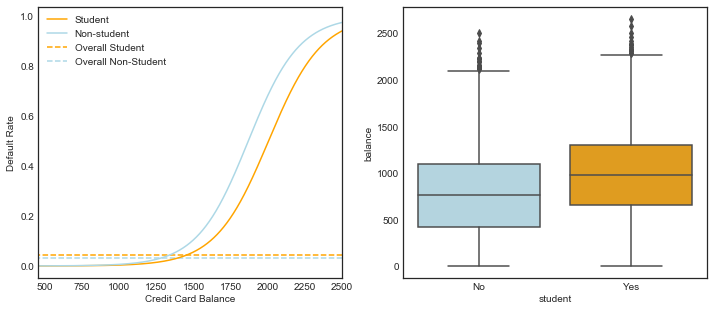

In [22]:
# creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.plot(X_test, pd.DataFrame(prob)[1], color='orange', label='Student')
ax1.plot(X_test, pd.DataFrame(prob2)[1], color='lightblue', label='Non-student')
ax1.hlines(127/2817, colors='orange', label='Overall Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(206/6850, colors='lightblue', label='Overall Non-Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

# Right plot
sns.boxplot('student', 'balance', data=df, orient='v', ax=ax2,  palette=c_palette);

>FIGURE 4.3. Confounding in the Default data. Left: Default rates are shown for students (orange) and non-students (blue). The solid lines display default rate as a function of balance, while the horizontal broken lines display the overall default rates. Right: Boxplots of balance for students (orange) and non-students (blue) are shown.


## 4.4 Linear Discriminant Analysis
### Table 4.4 


In [23]:
X = df[['balance', 'income', 'student2']].as_matrix()
y = df.default2.as_matrix()

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y).predict(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


>TABLE 4.4. A confusion matrix compares the LDA predictions to the true default statuses for the 10, 000 training observations in the Default data set. Elements on the diagonal of the matrix represent individuals whose default statuses were correctly predicted, while off-diagonal elements represent individuals that were misclassified. LDA made incorrect predictions for 23 individuals who did not default and for 252 individuals who did default.


In [24]:
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

             precision    recall  f1-score   support

         No       0.97      1.00      0.99      9667
        Yes       0.78      0.24      0.36       333

avg / total       0.97      0.97      0.97     10000



### Table 4.5
Instead of using the probability of 50% as decision boundary, we say that a probability of default of 20% is to be classified as 'Yes'.

In [25]:
decision_prob = 0.2
y_prob = lda.fit(X, y).predict_proba(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9435,140
Yes,232,193


> TABLE 4.5. A confusion matrix compares the LDA predictions to the true default statuses for the 10, 000 training observations in the Default data set, using a modified threshold value that predicts default for any individuals whose posterior default probability exceeds 20 %.



#### Figure 4-7

In [26]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y,y_prob[:,1],pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

In [27]:
# Original Method(Rough way)
df = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thres':thresholds})
df['FN'] = (1-df['tpr']) * 333
df['FP'] = (df['fpr']*9667)
df['error_rate'] = (df['FP'] + df['FN'])/10000

# default error:
# the fraction of defaulting customers that are incorrectly classfied.
df['default_error'] = (1 - df['tpr'])

# non_default error:
# the fraction of errors among the non-defaulting customers
# == false positive rates.

Text(0,0.5,'Error Rate')

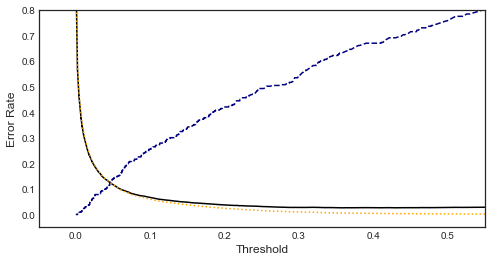

In [28]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
# overall error rate
plt.plot(df['thres'],df['error_rate'], c='k')
# default error rate
plt.plot(df['thres'],df['default_error'], c='navy',
        linestyle='--')
# non_default error rate
plt.plot(df['thres'],df['fpr'], c='orange',
        linestyle=':')

ax.set_ylim([-0.05,0.8])
ax.set_xlim([-0.05, 0.55])
ax.set_xlabel("Threshold", fontsize=12)
ax.set_ylabel("Error Rate", fontsize=12)

>FIGURE 4.7. For the Default data set, error rates are shown as a function of the threshold value for the posterior probability that is used to perform the assignment. The black solid line displays the overall error rate. The blue dashed line represents the fraction of defaulting customers that are incorrectly classified, and the orange dotted line indicates the fraction of errors among the non-defaulting customers.


#### Figure 4-8

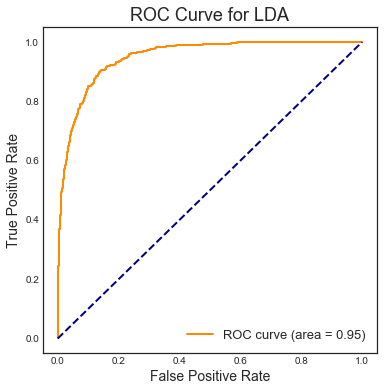

In [29]:
fig, ax =plt.subplots(1,1,figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", 
         label='ROC curve (area = %0.2f)' % roc_auc, lw=2)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='dashed')
ax.set_title("ROC Curve for LDA", fontsize=18)
ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14)
ax.legend(loc="lower right", fontsize=13)

>FIGURE 4.8. A ROC curve for the LDA classifier on the Default data. It traces out two types of error as we vary the threshold value for the posterior probability of default. The actual thresholds are not shown. The true positive rate is the sensitivity: the fraction of defaulters that are correctly identified, using a given threshold value. The false positive rate is 1-specificity: the fraction of non-defaulters that we classify incorrectly as defaulters, using that same threshold value. The ideal ROC curve hugs the top left corner, indicating a high true positive rate and a low false positive rate. The dotted line represents the “no information” classifier; this is what we would expect if student status and credit card balance are not associated with probability of default.


#### Figure 4-9

In [30]:
from scipy.stats import multivariate_normal
np.random.seed(1)
# Create Frozen objects for future use in Bayes Decision.
rv1_L = multivariate_normal([-1,-1], [[1,0.7],[0.7,1]])
rv2_L = multivariate_normal([1,1], [[1,0.7],[0.7,1]])
rv1_R = multivariate_normal([-1,-1], [[1,0.7],[0.7,1]])
rv2_R = multivariate_normal([1,1], [[1,-0.7],[-0.7,1]])

lnorm1 = rv1_L.rvs(50)
lnorm2 = rv2_L.rvs(50)
rnorm1 = rv1_R.rvs(50)
rnorm2 = rv2_R.rvs(50)

In [32]:
df_lclass0 = pd.DataFrame({'Y': 0, 'X1':lnorm1[:,0], 'X2':lnorm1[:,1]})
df_lclass1 = pd.DataFrame({'Y': 1, 'X1':lnorm2[:,0], 'X2':lnorm2[:,1]})
df_L = df_lclass0.append(df_lclass1)

df_rclass0 = pd.DataFrame({'Y': 0, 'X1':rnorm1[:,0], 'X2':rnorm1[:,1]})
df_rclass1 = pd.DataFrame({'Y': 1, 'X1':rnorm2[:,0], 'X2':rnorm2[:,1]})
df_R = df_rclass0.append(df_rclass1)

In [33]:
# Left
lda_L = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
qda_L = QuadraticDiscriminantAnalysis(store_covariance=True)
X = df_L[['X1','X2']]
y = df_L['Y']
lda_L.fit(X,y)
qda_L.fit(X,y)

# Right
lda_R = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
qda_R = QuadraticDiscriminantAnalysis(store_covariance=True)
X = df_R[['X1','X2']]
y = df_R['Y']
lda_R.fit(X,y)
qda_R.fit(X,y)

lda = [lda_L, lda_R]
qda = [qda_L, qda_R]

### 4.4.4 Quadratic Discriminant Analysis

#### Bayes Decision Boundary

In [36]:
def bayes_get_proba(data, rv1, rv2):
    return rv2.pdf([data[0],data[1]]) / (rv1.pdf([data[0],data[1]]) + rv2.pdf([data[0],data[1]]))
rv = [[rv1_L,rv2_L],
      [rv1_R,rv2_R]]

#### Plot

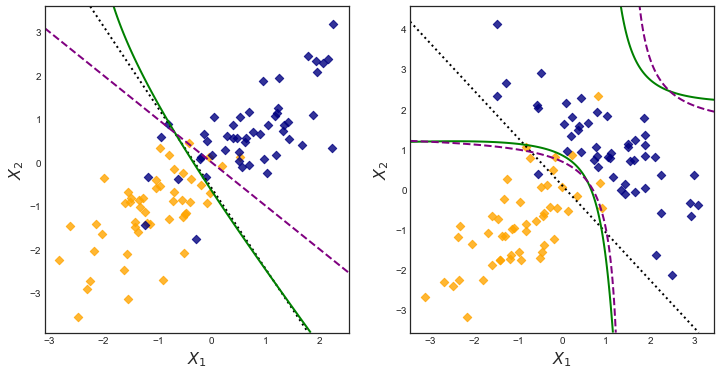

In [37]:
fig,axes = plt.subplots(1,2,figsize=(12,6))

# Left Scatter Plot
sns.regplot(df_lclass0['X1'],df_lclass0['X2'],ax=axes[0], 
            fit_reg=False, color='orange', marker='D')
sns.regplot(df_lclass1['X1'],df_lclass1['X2'],ax=axes[0], 
            fit_reg=False, color='navy', marker='D')

# Right Scatter Plot
sns.regplot(df_rclass0['X1'],df_rclass0['X2'],ax=axes[1], 
            fit_reg=False, color='orange', marker='D')
sns.regplot(df_rclass1['X1'],df_rclass1['X2'],ax=axes[1], 
            fit_reg=False, color='navy', marker='D')

nx, ny = 200, 200

for i in range(2):
    x_min, x_max = axes[i].get_xlim()
    y_min, y_max = axes[i].get_ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    
    # Decision Boundaries
    # LDA
    Z = lda[i].predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    axes[i].contour(xx, yy, Z, [0.5], linewidths=2., colors='k',
                   linestyles='dotted')
    # QDA
    Z = qda[i].predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    axes[i].contour(xx, yy, Z, [0.5], linewidths=2., colors='green',
                   linestyles='solid')
    
    # Bayes Decision Boundary
    Z = (pd.DataFrame({'x':xx.ravel(),'y':yy.ravel()})
        .apply(bayes_get_proba, args=(rv[i][0],rv[i][1]), axis=1)
        .values.reshape(xx.shape))
    
    axes[i].contour(xx, yy, Z, [0.5], linewidths=2., colors='purple',
                   linestyles='dashed')
    
for i in range(2):
    axes[i].set_xlabel('$X_{1}$', fontsize=16)
    axes[i].set_ylabel('$X_{2}$', fontsize=16)

>FIGURE 4.9. Left: The Bayes (purple dashed), LDA (black dotted), and QDA (green solid) decision boundaries for a two-class problem with Σ1 = Σ2. The shading indicates the QDA decision rule. Since the Bayes decision boundary is linear, it is more accurately approximated by LDA than by QDA. Right: Details are as given in the left-hand panel, except that Σ1 = Σ2. Since the Bayes decision boundary is non-linear, it is more accurately approximated by QDA than by LDA.


## 4.6 Lab

### 4.6.1 The Stock Market Data

In [41]:
df = pd.read_csv('Data/Smarket.csv', index_col=0, parse_dates=True)
df

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1246,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1247,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1248,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1249,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [42]:
df.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


In [43]:
df.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


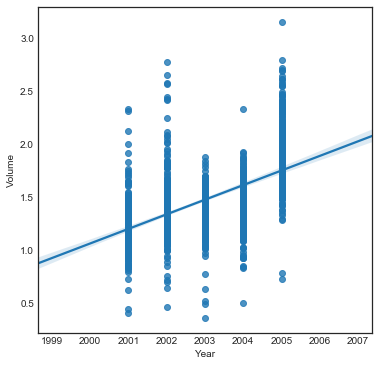

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
sns.regplot(df['Year'],df['Volume'], ax=ax)

### 4.6.2 Logistic Regression

In [50]:
df['Direction2'] = np.where(df['Direction'] == 'Up',1,0)
df

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction2
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up,1
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up,1
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down,0
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up,1
5,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up,1
...,...,...,...,...,...,...,...,...,...,...
1246,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up,1
1247,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down,0
1248,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up,1
1249,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down,0


In [52]:
est = smf.logit('Direction2 ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume', df).fit()
est.summary2()

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            No. Iterations:   4.0000   
Dependent Variable: Direction2       Pseudo R-squared: 0.002    
Date:               2018-05-26 02:19 AIC:              1741.5841
No. Observations:   1250             BIC:              1777.5004
Df Model:           6                Log-Likelihood:   -863.79  
Df Residuals:       1243             LL-Null:          -865.59  
Converged:          1.0000           Scale:            1.0000   
-----------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
-----------------------------------------------------------------
Intercept     -0.1260    0.2407  -0.5234  0.6007  -0.5978  0.3458
Lag1          -0.0731    0.0502  -1.4566  0.1452  -0.1714  0.0253
Lag2          -0.0423    0.0501  -0.8446  0.3984  -0.1405  0.0559
Lag3           0.0111    0.0499   0.2220  0.8243  -0.0868  0.1090
Lag4           0.0094    0.0500   0.1873  0.8514  -0.0886  0.1073
Lag5           0.0103    0.0495   0.2083  0.8350  -0.0867  0.1074
Volume         0.1354    0.1584   0.8553  0.3924  -0.1749  0.4458
================================================================

"""

In [53]:
est.params

Intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [55]:
# To get estimated probabilities, use est.predict
prob = est.predict(df[['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']])
prob.head()

1    0.507084
2    0.481468
3    0.481139
4    0.515222
5    0.510781
dtype: float64

In [58]:
#We can use predicted probabilities to get a confusion matrix
pred_direction = np.where(prob>0.5,"Up","Down")
pd.crosstab(pred_direction, df['Direction'])

Direction,Down,Up
row_0,,
Down,145,141
Up,457,507


#### Estimation with Train/Test Set

Now, create a Boolean list to subset train set in logit function

In [59]:
train = df['Year'] < 2005
df_test = df[~train]

In [61]:
est = smf.logit('Direction2 ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume', df,
               subset=train).fit()
est.summary2()

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            No. Iterations:   4.0000   
Dependent Variable: Direction2       Pseudo R-squared: 0.002    
Date:               2018-05-26 02:22 AIC:              1395.1052
No. Observations:   998              BIC:              1429.4454
Df Model:           6                Log-Likelihood:   -690.55  
Df Residuals:       991              LL-Null:          -691.63  
Converged:          1.0000           Scale:            1.0000   
-----------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
-----------------------------------------------------------------
Intercept      0.1912    0.3337   0.5730  0.5666  -0.4628  0.8452
Lag1          -0.0542    0.0518  -1.0462  0.2955  -0.1557  0.0473
Lag2          -0.0458    0.0518  -0.8843  0.3765  -0.1473  0.0557
Lag3           0.0072    0.0516   0.1394  0.8891  -0.0940  0.1084
Lag4           0.0064    0.0517   0.1246  0.9009  -0.0949  0.1078
Lag5          -0.0042    0.0511  -0.0826  0.9342  -0.1045  0.0960
Volume        -0.1163    0.2396  -0.4852  0.6276  -0.5859  0.3534
================================================================

"""

In [62]:
prob = est.predict(df_test[['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']])
pred_direction = np.where(prob>0.5,"Up","Down")

In [63]:
pd.crosstab(pred_direction, df_test['Direction'])

Direction,Down,Up
row_0,,
Down,77,97
Up,34,44


#### Estimation with Lag1, Lag2

In [64]:
est = smf.logit('Direction2 ~ Lag1 + Lag2', data=df, subset=train).fit()
est.summary2()

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            No. Iterations:   3.0000   
Dependent Variable: Direction2       Pseudo R-squared: 0.001    
Date:               2018-05-26 02:22 AIC:              1387.4021
No. Observations:   998              BIC:              1402.1193
Df Model:           2                Log-Likelihood:   -690.70  
Df Residuals:       995              LL-Null:          -691.63  
Converged:          1.0000           Scale:            1.0000   
-----------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
-----------------------------------------------------------------
Intercept      0.0322    0.0634   0.5084  0.6112  -0.0920  0.1564
Lag1          -0.0556    0.0517  -1.0757  0.2820  -0.1570  0.0457
Lag2          -0.0445    0.0517  -0.8611  0.3892  -0.1457  0.0568
================================================================

"""

In [65]:
prob = est.predict(df_test[['Lag1','Lag2']])
pred_direction = np.where(prob>0.5,"Up","Down")
pd.crosstab(pred_direction,df_test['Direction'])

Direction,Down,Up
row_0,,
Down,35,35
Up,76,106


In [67]:
# To predict with a particular lag1, lag2 value,
est.predict(pd.DataFrame({'Lag1':[1.2,1.5],'Lag2':[1.1,-0.8]}))

0    0.479146
1    0.496094
dtype: float64

### 4.6.3 Linear Discriminant Analysis

In [18]:
df = pd.read_csv('Data/Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)

In [19]:
X_train = df[:'2004'][['Lag1','Lag2']]
y_train = df[:'2004']['Direction']

X_test = df['2005':][['Lag1','Lag2']]
y_test = df['2005':]['Direction']

lda = LinearDiscriminantAnalysis()
pred = lda.fit(X_train, y_train).predict(X_test)

In [20]:
lda.priors_

array([ 0.49198397,  0.50801603])

In [21]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [22]:
# These do not seem to correspond to the values from the R output in the book?
lda.coef_

array([[-0.05544078, -0.0443452 ]])

In [23]:
confusion_matrix(y_test, pred).T

array([[ 35,  35],
       [ 76, 106]])

In [24]:
print(classification_report(y_test, pred, digits=3))

             precision    recall  f1-score   support

       Down      0.500     0.315     0.387       111
         Up      0.582     0.752     0.656       141

avg / total      0.546     0.560     0.538       252



In [25]:
pred_p = lda.predict_proba(X_test)

In [26]:
np.unique(pred_p[:,1]>0.5, return_counts=True)

(array([False,  True], dtype=bool), array([ 70, 182]))

In [27]:
np.unique(pred_p[:,1]>0.9, return_counts=True)

(array([False], dtype=bool), array([252]))

### 4.6.4 Quadratic Discriminant Analysis

In [28]:
qda = QuadraticDiscriminantAnalysis()
pred = qda.fit(X_train, y_train).predict(X_test)

In [29]:
qda.priors_

array([ 0.49198397,  0.50801603])

In [30]:
qda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [31]:
confusion_matrix(y_test, pred).T

array([[ 30,  20],
       [ 81, 121]])

In [32]:
print(classification_report(y_test, pred, digits=3))

             precision    recall  f1-score   support

       Down      0.600     0.270     0.373       111
         Up      0.599     0.858     0.706       141

avg / total      0.599     0.599     0.559       252



### 4.6.5 K-Nearest Neighbors

In [33]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)
print(classification_report(y_test, pred, digits=3))

[[43 58]
 [68 83]]
             precision    recall  f1-score   support

       Down      0.426     0.387     0.406       111
         Up      0.550     0.589     0.568       141

avg / total      0.495     0.500     0.497       252



In [34]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)
print(classification_report(y_test, pred, digits=3))

[[48 55]
 [63 86]]
             precision    recall  f1-score   support

       Down      0.466     0.432     0.449       111
         Up      0.577     0.610     0.593       141

avg / total      0.528     0.532     0.529       252



### 4.6.6 An Application to Caravan Insurance Data

#### K-Nearest Neighbors

In [35]:
# In R, I exported the dataset from package 'ISLR' to a csv file
df = pd.read_csv('Data/Caravan.csv')
y = df.Purchase
X = df.drop('Purchase', axis=1).astype('float64')
X_scaled = preprocessing.scale(X)

X_train = X_scaled[1000:,:]
y_train = y[1000:]
X_test = X_scaled[:1000,:]
y_test = y[:1000]

def KNN(n_neighbors=1, weights='uniform'):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    return(pred, score, clf.classes_)

def plot_confusion_matrix(cm, classes, n_neighbors, title='Confusion matrix (Normalized)',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix: KNN-{}'.format(n_neighbors))
    plt.colorbar()
    plt.xticks(np.arange(2), classes)
    plt.yticks(np.arange(2), classes)
    plt.tight_layout()
    plt.xlabel('True label',rotation='horizontal', ha='right')
    plt.ylabel('Predicted label')
    plt.show()

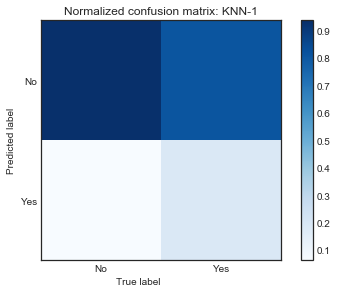

True        No  Yes
Predicted          
No         882   48
Yes         59   11
     Precision
No    0.948387
Yes   0.157143


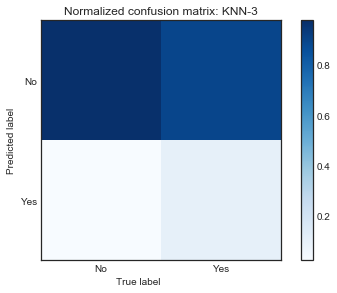

True        No  Yes
Predicted          
No         921   53
Yes         20    6
     Precision
No    0.945585
Yes   0.230769


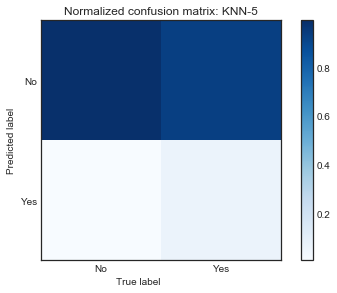

True        No  Yes
Predicted          
No         934   55
Yes          7    4
     Precision
No    0.944388
Yes   0.363636


In [36]:
for i in [1,3,5]:
    pred, score, classes = KNN(i)
    cm = confusion_matrix(y_test, pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized.T, classes, n_neighbors=i)
    cm_df = pd.DataFrame(cm.T, index=classes, columns=classes)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print(cm_df)    
    print(pd.DataFrame(precision_score(y_test, pred, average=None),
                       index=classes, columns=['Precision']))        

####  Logistic Regression

In [37]:
regr = skl_lm.LogisticRegression()
regr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
pred = regr.predict(X_test)
cm_df = pd.DataFrame(confusion_matrix(y_test, pred).T, index=regr.classes_,
                     columns=regr.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)
print(classification_report(y_test, pred))

True        No  Yes
Predicted          
No         935   59
Yes          6    0
             precision    recall  f1-score   support

         No       0.94      0.99      0.97       941
        Yes       0.00      0.00      0.00        59

avg / total       0.89      0.94      0.91      1000



In [39]:
pred_p = regr.predict_proba(X_test)
cm_df = pd.DataFrame({'True': y_test, 'Pred': pred_p[:,1] > .25})
cm_df.Pred.replace(to_replace={True:'Yes', False:'No'}, inplace=True)
print(cm_df.groupby(['True', 'Pred']).size().unstack('True').T)
print(classification_report(y_test, cm_df.Pred))

Pred   No  Yes
True          
No    919   22
Yes    48   11
             precision    recall  f1-score   support

         No       0.95      0.98      0.96       941
        Yes       0.33      0.19      0.24        59

avg / total       0.91      0.93      0.92      1000

